# Project: Investigate A Dataset - Titanic Data
This report is for the final project of the *Introduction to Data Analysis* course on Udacity. I choose to work with the Titanic dataset from the [Kaggle website](https://www.kaggle.com/c/titanic/data) for this project. First, I will pose a question related to this dataset. I will then make use of what I have learned in the course to cleanse and explore the data.

## 1 Questions to Answer
The data contains demographics and information of 891 out of 2,224 passengers and crew on board the Titanic. As one of the deadliest peacetime maritime disasters in history, what I am most concerned about is the casualties and survivors. How many survivors in the disaster and what makes them survive? Is a single person more likely to survive than a whole family? Does a child have more chances to survive than an adult? Or does the ticket class matter? I will explore these questions in deep below.

## 2 Data Summary
Now I will first aquire the dataset and take a peek at it.

In [202]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [203]:
# Load in the titanic csv file as a DataFrame
titanic_df = pd.read_csv('titanic-data.csv')

# Preview the data
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [204]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [205]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


There are 891 observations of 12 variables in the dataset. The description of each variable is illustrated on the [Kaggle website](https://www.kaggle.com/c/titanic/data). From the first few observations and descriptive summary above, we are able to tell some initial sense about the data.

**Data type of variables:**
- Categorical: **Survived**, **Pclass**, **Sex**, **Embarked**
- Ratio: **Age**, **SibSp**, **Parch**, **Fare**
- Other: **Name**, **Ticket**, **Cabin**

**Variables that may contain nulls or errors:**
- There are less than 891 of valid inputs in **Age**, **Cabin** and **Embarked**, which may contain blanks or nulls and require completing.
- There are titles, first and last name, and alternative name in parenthesis in **Name**. It may require correcting or dropping.

**Some facts:**
- 38.38% of passengers in the sample survived.
- More than half of the passengers were in the third ticket class.
- 3/4 of them were under 38 years old. There might be few elderly people on board.
- Less than half of passengers traveled with their spouse or siblings, and most of them did not have their children or parents aboard.
- The distribution of fare might display a very long right tail - with $512 as the top price.

## 3 Data Wrangling
Based on the brief desciptions above, we proceed to data wrangling process and clean the data by following steps:
- **PassengerId** and **Name**: drop variables because there is no relationship with survival on common sense
- **Age**: complete blanks; integrate with **Sex** and create a new variable **Person** with categories of child, female, and male
- **SibSp** and **Parch**: integrate to create a new variable **Family** with number of family members aboard; create a new dummy variable **IsAlone** to describe whether or not the person was aboard alone
- **Ticket** and **Cabin**: drop variables because too many N/A values in these columns and there is no relationship with survival on common sense
- **Embarked**: complete blanks

### 3.1 Age
One of the simplest way to complete null values is to generate random numbers from mean and standard deviation. We can also use other correlated variables to simulate missing values in **Age**, but it seems too complicated for this dataset. So I am going to use the easier way at this moment.

In [206]:
# Drop variables we do not need
titanic_df = titanic_df.drop(['Name', 'PassengerId', 'Ticket', 'Cabin'], axis = 1)

# Change Fare data to integers
titanic_df['Fare'] = titanic_df['Fare'].astype(int)

In [207]:
# Get mean, standard deviation and no. of nulls in Age
age_avg = titanic_df['Age'].mean()
age_std = titanic_df['Age'].std()
age_null = titanic_df['Age'].isnull().sum()

print age_null

177


In [208]:
# There are 177 null values in Age!
# Generate random numbers between one standard deviation from the mean
age_rand = np.random.randint(age_avg - age_std, high=age_avg + age_std, size=age_null)

In [209]:
# Create a new variable NewAge and fill in the null values
titanic_df['NewAge'] = titanic_df['Age']
titanic_df['NewAge'][np.isnan(titanic_df['NewAge'])] = age_rand

titanic_df['Age'] = titanic_df['Age'].dropna().astype(int)
titanic_df['NewAge'] = titanic_df['NewAge'].astype(int)

/Applications/anaconda/envs/DAND/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Now we can plot the original and new age data to see whether the null values are completed well.

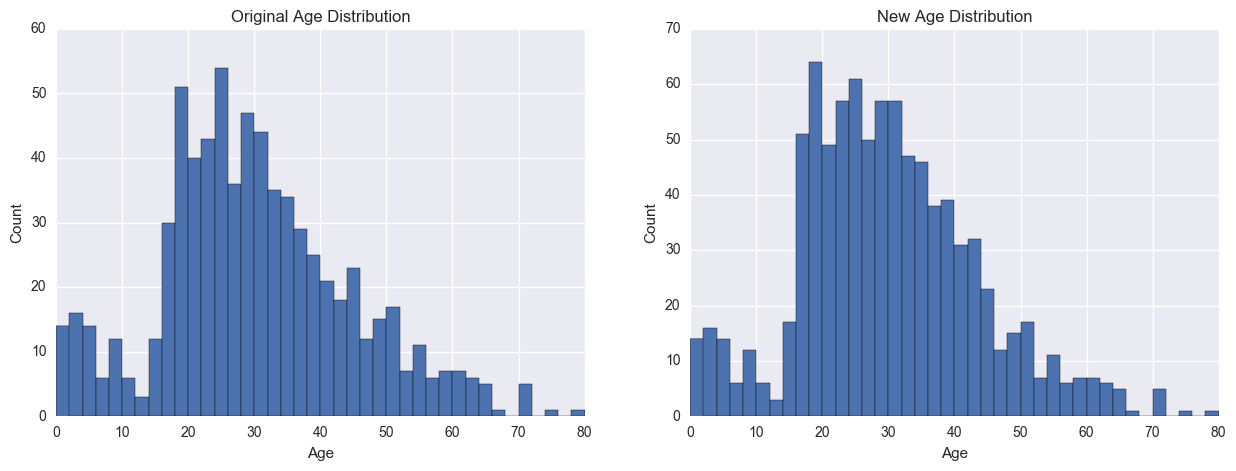

In [210]:
# Plot the original and new age data
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 5))
axis1.set_title('Original Age Distribution')
axis2.set_title('New Age Distribution')
axis1.set_xlabel('Age')
axis2.set_xlabel('Age')
axis1.set_ylabel('Count')
axis2.set_ylabel('Count')

titanic_df['Age'].dropna().hist(bins=40, ax=axis1)
titanic_df['NewAge'].hist(bins=40, ax=axis2)

From the two graphs above we can tell that the new age data has similar distribution with the original data. We can drop the old data and do analysis with the new one.

In [211]:
# Drop old age data
titanic_df['Age'] = titanic_df['NewAge']
titanic_df = titanic_df.drop(['NewAge'], axis=1)

In [212]:
# Create a new variable Person with categories of child, female and male
titanic_df['Person'] = titanic_df['Sex']
titanic_df['Person'].loc[titanic_df['Age'] < 16] = 'Child'
titanic_df['Person'] = titanic_df['Person'].replace({'female':'Female', 'male':'Male'})

# Drop Sex
titanic_df = titanic_df.drop(['Sex'], axis=1)

### 3.2 Family

In [213]:
# Create a new variable Family to count the number of family member aboard
titanic_df['Family'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

# Also create a new dummy variable IsAlone by Family
titanic_df['IsAlone'] = 'With Family'
titanic_df['IsAlone'].loc[titanic_df['Family'] == 1] = 'Alone'

In [214]:
# Drop SibSp and Parch
titanic_df = titanic_df.drop(['SibSp', 'Parch'], axis=1)

### 3.3 Embarked

In [215]:
# Complete nulls in Embarked with the most frequent embarkment
emb_mode = titanic_df['Embarked'].dropna().mode()[0]
titanic_df['Embarked'] = titanic_df['Embarked'].fillna(emb_mode)

In [216]:
# Replace embarkment name instead of abbreviations
titanic_df['Embarked'] = titanic_df['Embarked'].replace({'C':'Cherbourg', 'Q':'Queenstown', 'S':'Southampton'})

In [217]:
# Create a descriptive variable to describe the survival status
titanic_df['Survived_d'] = 'Survived'
titanic_df['Survived_d'].loc[titanic_df['Survived'] == 0] = 'Not Survived'

### 3.4 Summary

In [218]:
titanic_df.head()

,Survived,Pclass,Age,Fare,Embarked,Person,Family,IsAlone,Survived_d
0,0,3,22,7,Southampton,Male,2,With Family,Not Survived
1,1,1,38,71,Cherbourg,Female,2,With Family,Survived
2,1,3,26,7,Southampton,Female,1,Alone,Survived
3,1,1,35,53,Southampton,Female,2,With Family,Survived
4,0,3,35,8,Southampton,Male,1,Alone,Not Survived


In [219]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Age           891 non-null int64
Fare          891 non-null int64
Embarked      891 non-null object
Person        891 non-null object
Family        891 non-null int64
IsAlone       891 non-null object
Survived_d    891 non-null object
dtypes: int64(5), object(4)
memory usage: 62.7+ KB


In [220]:
titanic_df.describe()

,Survived,Pclass,Age,Fare,Family
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.456790,31.785634,1.904602
std,0.486592,0.836071,13.593417,49.703730,1.613459
min,0.000000,1.000000,0.000000,0.000000,1.000000
25%,0.000000,2.000000,20.000000,7.000000,1.000000
50%,0.000000,3.000000,28.000000,14.000000,1.000000
75%,1.000000,3.000000,38.000000,31.000000,2.000000
max,1.000000,3.000000,80.000000,512.000000,11.000000


We can see that after data wrangling, the dataset is cleaned up and we can start explore it.

## 4  Exploration

### 4.1 Does natural demographics matter?
If there were a rescue team aside the sunking Titanic, it is reasonable to save the children and women at first. So we will first take a look at the **Age** and **Person** data.

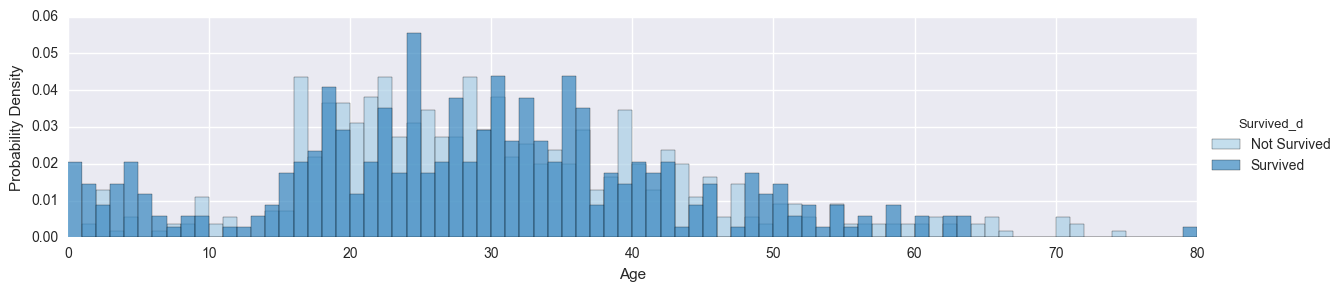

In [221]:
# Draw a graph of survival probability density by age
age_max = titanic_df['Age'].max()

age_facet = sns.FacetGrid(titanic_df, hue='Survived_d', aspect=4, palette='Blues')
age_facet.map(plt.hist, 'Age', normed=True, bins=age_max, range=(0,age_max), alpha=0.7)
age_facet.set(xlim=(0, age_max))
age_facet.set_ylabels('Probability Density')
age_facet.add_legend()

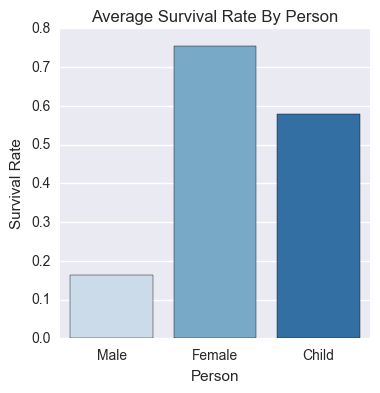

In [222]:
# Draw a graph of average survived passengers by female, male and child
fig, axis1 = plt.subplots(1, 1, figsize=(4,4))
axis1.set_title('Average Survival Rate By Person')
sur_ave_per = titanic_df[['Person', 'Survived']].groupby(['Person'], as_index=False).mean()

sns.barplot(x='Person', y='Survived', data=sur_ave_per, order=('Male', 'Female', 'Child'), palette='Blues')
axis1.set_xlabel('Person')
axis1.set_ylabel('Survival Rate')

From the graphs above, we may be able to tell that:
- A child had a higher survival rate compared to an adult.
- A woman had a higher survival rate compared to a man.
- It is not easy to draw a conclusion on the elderly person because of insufficient data points.

To make an evidental conclusion, now I am going to use statistical method to conduct tests. I test the means of **Survived** by different **Person** groups. The null hypothesis is that the means of **Survived** are equal for each two of the groups. I use 95% significant level for the two-sided t-tests of independent samples.

In [223]:
# Create groups of survival for t-test
child_sur = titanic_df[titanic_df['Person'] == 'Child']['Survived']
female_sur = titanic_df[titanic_df['Person'] == 'Female']['Survived']
male_sur = titanic_df[titanic_df['Person'] == 'Male']['Survived']

In [224]:
# Define a function to report test results
def test_result(a, b):
    t = stats.ttest_ind(a, b)[0]
    p_value = stats.ttest_ind(a, b)[1]
    if p_value < 0.05:
        print 'We reject the null hypothesis because the p-value is less than 0.05.'
    else:
        print 'We are not able to reject the null hypothesis because the p-value is larger than 0.05.'

In [225]:
# Conduct t-test between groups
print 'Child & Female t-test result:'
test_result(child_sur, female_sur)
print '-' * 70
print 'Child & Male t-test result:'
test_result(child_sur, male_sur)
print '-' * 70
print 'Female & Male t-test result:'
test_result(female_sur, male_sur)

Child & Female t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
Child & Male t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
Female & Male t-test result:
We reject the null hypothesis because the p-value is less than 0.05.


From the test results, each of the **Person** groups has different mean of **Survived** from the others. And based on the graphs above, we can tell that female had the highest survival rate among all groups, followed by child, and male at the last rank.

### 4.2 Does family help survival?
Is the family size related to survival? Take a look at the graphs first.

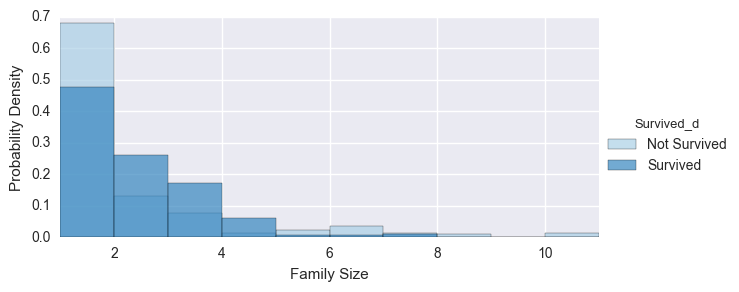

In [226]:
# Draw a graph of survival probability density by family size
family_max = titanic_df['Family'].max()

family_facet = sns.FacetGrid(titanic_df, hue='Survived_d', aspect=2, palette='Blues')
family_facet.map(plt.hist, 'Family', normed=True, bins=family_max, range=(0,family_max), alpha=0.7)
family_facet.set(xlim=(1, family_max))
family_facet.set_xlabels('Family Size')
family_facet.set_ylabels('Probability Density')
family_facet.add_legend()

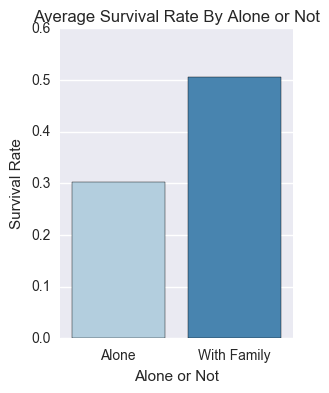

In [227]:
# Draw a graph of average survived passengers by alone or not
fig, axis1 = plt.subplots(1, 1, figsize=(3,4))
axis1.set_title('Average Survival Rate By Alone or Not')
sur_ave_alone = titanic_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

sns.barplot(x='IsAlone', y='Survived', data=sur_ave_alone, palette='Blues')
axis1.set_xlabel('Alone or Not')
axis1.set_ylabel('Survival Rate')

From the graphs above, we can see that there might be a survival penalty for alone person and family with size larger than 4. I will test the means of **Survived** by different family size as what I do in Section 4.1.

In [228]:
# Create groups of survival for t-test
alone_sur = titanic_df[titanic_df['IsAlone'] == 'Alone']['Survived']
small_family_sur = titanic_df[titanic_df['Family'] <= 4]['Survived']
large_family_sur = titanic_df[titanic_df['Family'] > 4]['Survived']

In [229]:
# Conduct t-test between groups
print 'Singleton & Small Family t-test result:'
test_result(alone_sur, small_family_sur)
print '-' * 70
print 'Singleton & Large Family t-test result:'
test_result(alone_sur, large_family_sur)
print '-' * 70
print 'Small Family & Large Family t-test result:'
test_result(small_family_sur, large_family_sur)

Singleton & Small Family t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
Singleton & Large Family t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
Small Family & Large Family t-test result:
We reject the null hypothesis because the p-value is less than 0.05.


From the test results, we can tell that alone person and large family definitely suffered a survival penalty compared to small family.

### 4.3 What about embarked characteristics?

I am going to discuss about **Pclass**, **Embarked** and **Fare**. Again, let's begin with the plots.

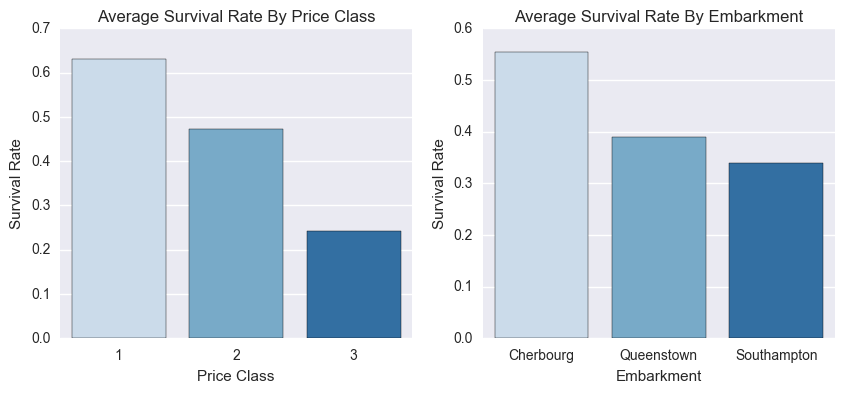

In [230]:
# Draw a graph of average survived passengers by price class and embarkment
fig, (axis1, axis2) = plt.subplots(1, 2, figsize=(10,4))
axis1.set_title('Average Survival Rate By Price Class')
axis2.set_title('Average Survival Rate By Embarkment')

sur_ave_pc = titanic_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
sns.barplot(x='Pclass', y='Survived', data=sur_ave_pc, palette='Blues', ax=axis1)
axis1.set_xlabel('Price Class')
axis1.set_ylabel('Survival Rate')

sur_ave_em = titanic_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()
sns.barplot(x='Embarked', y='Survived', data=sur_ave_em, palette='Blues', ax=axis2)
axis2.set_xlabel('Embarkment')
axis2.set_ylabel('Survival Rate')

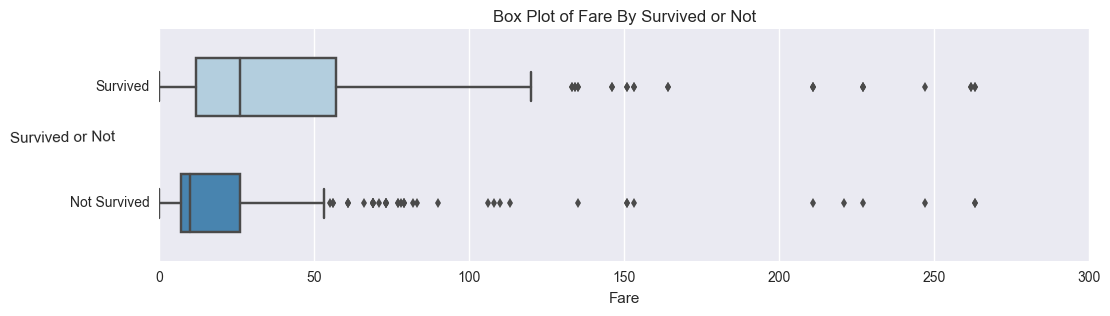

In [231]:
# Draw a box plot of fare by survived or not
# Since only one data point was with price over $300, I set a limit for fare to better view the box plot.
fig, axis1 = plt.subplots(1, 1, figsize=(12,3))
axis1.set_title('Box Plot of Fare By Survived or Not')

sns.boxplot(x='Fare', y='Survived_d', data=titanic_df, order=('Survived', 'Not Survived'), \
            orient='h', palette='Blues', width=0.5, ax=axis1)
axis1.set_xlim(0, 300)
axis1.set_ylabel('Survived or Not', rotation=True)

From the graphs above, we may be able to tell that:
- People with higher price class might have higher survival rate.
- People embarked from Cherbourg might have higher survival rate than those from Queenstown and Southampton.
- The fare of survived people was widely spread, while that of who did not survive was narrowly distributed.

Since the fare and the price class is positively related, I am going to test the means of **Survived** by different **Pclass** and **Embarked** groups. The null hypothesis and the significant level are the same as below tests.

In [232]:
# Create groups of survival for t-test
first_sur = titanic_df[titanic_df['Pclass'] == 1]['Survived']
second_sur = titanic_df[titanic_df['Pclass'] == 2]['Survived']
third_sur = titanic_df[titanic_df['Pclass'] == 3]['Survived']

In [233]:
# Conduct t-test between groups
print '1st Class & 2nd Class t-test result:'
test_result(first_sur, second_sur)
print '-' * 70
print '1st Class & 3rd Class t-test result:'
test_result(first_sur, third_sur)
print '-' * 70
print '2nd Class & 3rd Class t-test result:'
test_result(second_sur, third_sur)

1st Class & 2nd Class t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
1st Class & 3rd Class t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
2nd Class & 3rd Class t-test result:
We reject the null hypothesis because the p-value is less than 0.05.


In [234]:
# Create groups of survival for t-test
cher_sur = titanic_df[titanic_df['Embarked'] == 'Cherbourg']['Survived']
queen_sur = titanic_df[titanic_df['Embarked'] == 'Queenstown']['Survived']
south_sur = titanic_df[titanic_df['Embarked'] == 'Southampton']['Survived']

In [235]:
# Conduct t-test between groups
print 'Cherbourg & Queenstown t-test result:'
test_result(cher_sur, queen_sur)
print '-' * 70
print 'Cherbourg & Southampton t-test result:'
test_result(cher_sur, south_sur)
print '-' * 70
print 'Queenstown & Southampton t-test result:'
test_result(queen_sur, south_sur)

Cherbourg & Queenstown t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
Cherbourg & Southampton t-test result:
We reject the null hypothesis because the p-value is less than 0.05.
----------------------------------------------------------------------
Queenstown & Southampton t-test result:
We are not able to reject the null hypothesis because the p-value is larger than 0.05.


From the test results, each of the **Pclass** groups has different mean of **Survived** from the others. And based on the graphs above, we can tell that the higher the price class was, the higher survival rate was.
Also, people embarked from Cherbourg had higher survival rate than those embarked from Queenstown and Southampton.

## 5 Conclusion

Based on the graphs and statistical test results, I am going to make some conclusions to the questions mentioned in Section 1.
- Female and child were more likely to survive than male. People would let women and children to leave from the sinking ship to lifeboats, which increased the survival rate of these two groups.
- Singleton and large family had a survival penalty compared to small family. People could receive help from family members, but too large family size might hinder the rescue process.
- Higher price class might result in higher survival rate. People with higher social class would have more information when the ship began to sink, and might have more ways to save their life.
- People embarked from Cherbourg had higher survival rate than those embarked from Queenstown and Southampton. There are not enough information about these three embarkment, so it is hard to see a link between embarkment and survival.

The results of analysis still has some limitations:
- The missing **Age** data is simulated in a simple way. There may be bias since the distribution is a bit positively skewed.
- There are more first class tickets than second class tickets, which is not common to regular shipping tickets. There may be sample bias since the sample contains 891 out of 2,224 passengers and crew data points.
- There are a lot of missing values in **Cabin** such that I am not able to analyze it. We might obtain more information if the data is complete.

## Reference
[1]Data source: [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/data)

[2]Python documentations:

[numpy.random.randint](https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.random.randint.html)

[seaborn.FacetGrid](http://seaborn.pydata.org/generated/seaborn.FacetGrid.html)

[seaborn.barplot](http://seaborn.pydata.org/generated/seaborn.barplot.html)

[matplotlib.pyplot](http://matplotlib.org/api/pyplot_api.html)

[pandas.DataFrame.plot](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html)

[pandas.DataFrame.replace](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html)